<a href="https://colab.research.google.com/github/jaiwon880/DeepLearning_jw/blob/main/jaiwon880/DeepLearning_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet

## 환경설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# USE_CUDA : 계산을 가속해주는 CUDA를 쓸 수 있는지 확인하는 코드
# DEVICE : USE_CUDA의 결과에 따라 데이터를 CUDA(GPU) 혹은 CPU로 보내도록 가리키는 역할
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
# 컬러 데이터셋이라 좀 더 학습해야함
EPOCHS = 300
BATCH_SIZE = 128

## 데이터셋 불러오기

In [ ]:
# 데이터셋 이름만 바꿔주면 됨
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4), # 과적합 방지 (4px 여유를 두고 자르기)
                       transforms.RandomHorizontalFlip(), # 확률적으로 좌우 반전
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,0.5,0.5), 
                                            (0.5,0.5,0.5)),
                                            ])),# 색상 정규화
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

dataiter = iter(train_loader)
images, labels = next(dataiter)

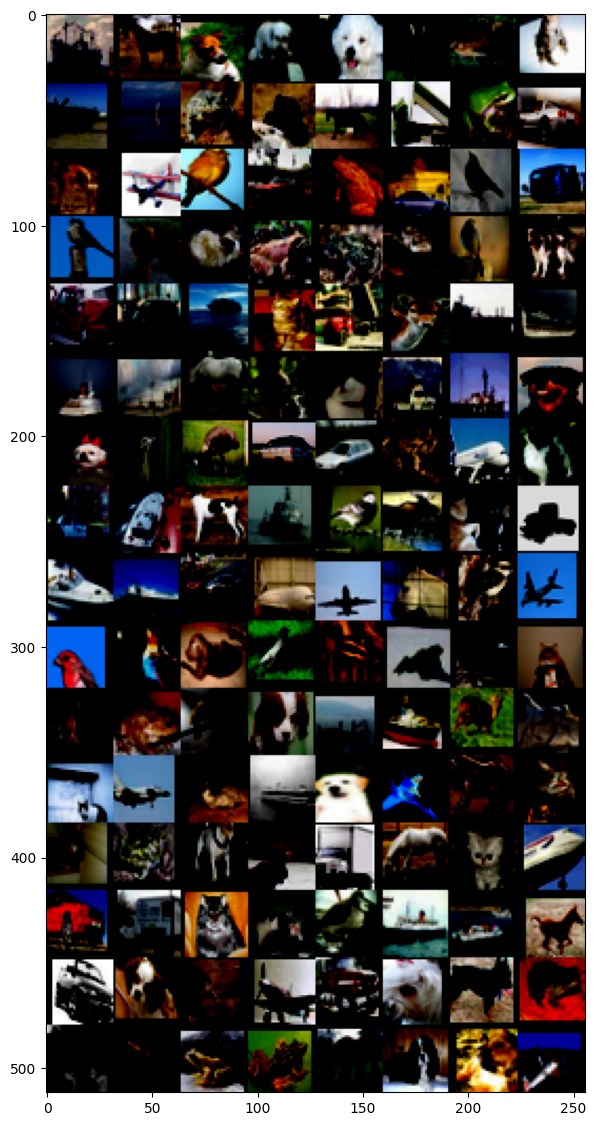

In [ ]:
img = utils.make_grid(images, padding=0)
npimg = img.numpy()

plt.figure(figsize=(20, 14))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# ResNet 모델 만들기
* 메인 모델 > Residual 신경망 (반복적)
* ResNet > BasicBlock

In [ ]:
# Residual 블록을 BasicBlock이라는 새로운 파이토치 모듈로 정의해서 사용
# 파이토치에서는 nn.Module을 이용하여 모듈 위에 또 다른 모듈을 쌓아올릴 수 있음
# Conv2d나 Linear 같은 모듈도 모두 nn.Module을 통해서 이미 만들어진 걸 사용
class BasicBlock(nn.Module):
    # in_planes 하위 모듈의 들어온 입력값, planes : 출력값
    def __init__(self, in_planes, planes, stride=1): # 상위 모델에서 값을 전달 받아서 사용
        super(BasicBlock, self).__init__()

        # 입력층 in_planes, 출력층 : planes, 커널 사이즈 3, 스트라이드 1, 주변에 여백 1
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # nn.BatchNorm2d : 배치정규화 batch normalization
        # 배치 정규화 : 학습률 learning rate 을 너무 높게 잡아서, 기울기가 소실되거나 발산(폭발)하는 증상을 예방하여
        # 학습 과정을 안정화시키는 역할
        # 즉, 학습 중에 각 계층에 들어가는 입력을 배치 단위로 평균과 분산으로 정규화함으로써 학습을 효율적으로 만들어줌
        # 드롭아웃과 기능상으로 유사? -> 차이점
        # 드롭아웃 -> 학습 중 데이터 일부, 노드 일부를 배제하여서 간접적으로 과적합을 막는 방식
        # 배치 정규화 -> 신경망 내부 데이터에 직접 영향을 주는 방식
        self.bn1 = nn.BatchNorm2d(planes)

        # 입력 -> 출력 채널로 바뀌고
        # kerenl_size랑 padding이랑 서로 속성에 상쇄를 시키고
        # stride = 1은 1/n 해서 속성 값을 줌
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # ResNet의 두 번째 블록 -> in_planes -> self.bn2 계층의 출력 크기와 같은 planes와 더해주는 self.shortcut 모듈을 정의
        self.shortcut = nn.Sequential() # 빈 시퀀셜 -> 그냥 지나감 (pass)
        if stride != 1 or in_planes != planes: # <-> stride = 1, 입력과 출력의 크기가 같으면. (원본 이미지를 그냥 통과시키고 변형 시킬 필요가 없으면)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        # nn.Sequential은 여러 모듈(nn.Module)들을 하나의 모듈로 묶는 역할
        # 각 레이어를 데이터가 순차적으로 지나갈 때 사용하면 코드를 간결하게 만들 수 있음
        # → 계층과 활성화 함수를 정의해주면 순서대로 값을 전달해서 처리 (중간에 변형이나 추가적인 텐서 작업 X)

    def forward(self, x):
        # 입력 x가 들어와 컨볼루션, 배치 정규화, 활성화 함수를 거치게 함
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 다시 입력 x를 self.shortcut을 거치게 하여 크기를 같게 하고 활성화 함수를 거친 값에 원본 값을 더해줌
        out += self.shortcut(x) # 합 연산을 통해서 이전 이전 블록에서 처리되었던 특징을 겹쳐줌
        # 텐서 간 연산 -> 원본을 특징 추출한 특징맵에 겹쳐줌

        # 최종적으로 ReLU 활성화 함수 통과 시켜서 최종 출력
        out = F.relu(out)        

        return out

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv1 = nn.Conv2d(planes, planes, kernel_size =3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes ! = planes: 
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes)
          )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(x))
        out += self.shortcut(x) 
        out = F.relu(out)
        

        return out

In [ ]:
# 이미지를 받아서 컨볼루션과 배치 정규화 층을 거친 후, 여러 **BasicBlock** 층을 통과하고
# 평균 풀링과 신경망을 거쳐 예측을 출력 ResNet
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        # self.in_planes : self._make_layers() 함수 -> 각 층을 만들 때
        # 전 층의 채널 출력값을 기록하는 데 쓰임

        # layer1 층은 입력받는 채널의 개수가 16개 
        # 3 -> 16개. -> basic block 으로 만든 레이어 1의 입력값 16.
        self.in_planes = 16

        # 첫 self.conv1 -> 3×3의 커널 크기 -> 이미지가 갖고 있던 RGB 3색의 채널을 16개로 만듦
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(16) # 분류된 속성 크기
        # 3. 32. 32 -> 16. 32. 32

        # BasicBlock을 생성해주는 함수 -> self._make_layer()
        # nn.Sequential을 사용해서 여러 BasicBlock을 하나로 묶어서 사용 -> 층. -> 모듈.
        self.layer1 = self._make_layer(16, 2, stride=1) # 16 입력값. 2. 내부에 사용될 BasicBlock의 갯수
        # 16 x 32 x 32 / self.in_planes : 16 -> 16
        self.layer2 = self._make_layer(32, 2, stride=2) # 2번째 레이어, 1번째 레이어 블록에서 short-cut 발동
        # 32 x 16 x 16 / self.in_planes : 16 -> 32
        self.layer3 = self._make_layer(64, 2, stride=2) # 3번째 레이어, 1번째 레이어 블록에서 short-cut 발동
        # 64 x 8 x 8 / self.in_planes : 32 -> 64

        # 마지막으로 평균 풀링으로 텐서에 있는 원소의 개수를 64개로 만든 후, 64개의 입력을 받아 레이블(10개)마다 예측값을 내게 됨
        # <...> forword할 때 F.avg pooling...
        self.linear = nn.Linear(64, num_classes) # 여기서 왜 64를 씀 아래에서 out = F.avg_pool2d(out, 8) 평균값 처리 땜에

        # layer1 : 16채널에서 16채널을 내보내는 BasicBlock 2개
        # layer2 : 16채널을 받아 32채널을 출력하는 BasicBlock 1개와 32채널에서 32채널을 내보내는 BasicBlock 1개
        # layer3 : 32채널을 받아 64채널을 출력하는 BasicBlock 1개와 64채널에서 64채널을 출력하는 BasicBlock 1개

        # 주목해야하는 건 16채널을 받아 32채널을 출력하는 BasicBlock과 32채널을 받아 64채널을 출력하는 BasicBlock
        # 이렇게 증폭하는 역할을 하는 모듈들은 shortcut 모듈을 따로 갖게 됨
        # shortcut 모듈은 이전 입력 을 중간층에 더해주어 이미지의 맥락이 보존될 수 있도록 하는 역할을 함
    
    def _make_layer(self, planes, num_blocks, stride):
        # 멤버 변수인 self.in_planes 채널 개수로부터 (입력값),
        # 직접 입력받는 인수인 planes 채널 개수만큼을 출력하는 BasicBlock 블록을 생성 (출력값)
        strides = [stride] + [1] * (num_blocks - 1)
        # 리스트 연산
        # [1] + [1] * (2-1) = [1] + [1] = [1, 1]
        # 무조건 최초의 stride는 외부에서 전달받은 값이고, 그 다음엔 무조건 1이 모듈 개수만큼 반복
        layers = [] # 이 변수를 통해 생성될 계층
        for stride in strides:
            # num_blocks가 2이고, stride가 2인 값을 전달 받았다 strides = [2, 1]
            # num_blocks가 2이고, stride가 1인 값을 전달 받았다 strides = [1, 1]
            layers.append(BasicBlock(self.in_planes, planes, stride))
            # 한 번 레이어를 만들고 나서, 해당 레이어의 Output이 곧 다음 레이어의 인풋
            self.in_planes = planes
        return nn.Sequential(*layers) # layers에 있는 원소들을 리스트가 아니라, 원소 하나씩 별도로 패러미터로 전달하겠다
        # nn.Sequential -> 전달 받은 매개변수 순서대로 처리하는 신경망을 만들어주겠다 
    
    def forward(self, x):
        # 입력이 들어오면 일반적인 방식과 같이, 컨볼루션, 배치 정규화, 활성화 함수를 차례대로 통과
        # 사전에 정의해둔 BasicBlock 층을 갖고 있는 layer1, layer2, 그리고 layer3를 통과
        # 각 layer는 2개의 esidual 블록을 갖고 있음
        out = F.relu(self.bn1(self.conv1(x))) # 3 -> 16 채널로 변환
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # 이렇게 나온 값에 평균 풀링을 하고 마지막 계층을 거쳐서 분류 결과 출력
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1) # out.size(0) = 미니 배치사이즈
        # out = out.view(-1, 64)
        out = self.linear(out) # 10개 특성
        return out

In [ ]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
# 학습 효율을 높이기 위해 학습률 감소 learning rate decay 기법을 사용
# 학습률 감소는 학습이 진행하면서 최적화 함수의 학습률을 점점 낮춰서 더 정교하게 최적화
# 파이 토치 내부의 optim.lr_scheduler.StepLR 도구를 사용해 간단하게 적용
# Scheduler는 이폭마다 호출되며 step_size를 50으로 지정해주어 50번 호출될 때 학습률에 0.1 (gamma값)을 곱함
# 0.1로 시작한 학습률은 50 이후에 0.01로 낮아짐
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
# 계층 보기
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
from torchsummary import summary as summary_

summary_(model, (3, 32, 32), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 32, 32]             432
       BatchNorm2d-2          [128, 16, 32, 32]              32
            Conv2d-3          [128, 16, 32, 32]           2,304
       BatchNorm2d-4          [128, 16, 32, 32]              32
            Conv2d-5          [128, 16, 32, 32]           2,304
       BatchNorm2d-6          [128, 16, 32, 32]              32
        BasicBlock-7          [128, 16, 32, 32]               0
            Conv2d-8          [128, 16, 32, 32]           2,304
       BatchNorm2d-9          [128, 16, 32, 32]              32
           Conv2d-10          [128, 16, 32, 32]           2,304
      BatchNorm2d-11          [128, 16, 32, 32]              32
       BasicBlock-12          [128, 16, 32, 32]               0
           Conv2d-13          [128, 32, 16, 16]           4,608
      BatchNorm2d-14          [128, 32,

![ResNet](https://github.com/BigData23th/Data/raw/main/dl_03_11.png)
> 이번 ResNet 모델 구조

In [ ]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
# 평가 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step() # 학습률을 낮춰줌
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1] Test Loss: 1.3780, Accuracy: 49.65%
[2] Test Loss: 1.1807, Accuracy: 58.16%
[3] Test Loss: 1.2886, Accuracy: 58.48%
[4] Test Loss: 0.7974, Accuracy: 71.88%
[5] Test Loss: 1.4592, Accuracy: 58.95%
[6] Test Loss: 0.7578, Accuracy: 74.31%
[7] Test Loss: 0.8274, Accuracy: 71.99%
[8] Test Loss: 0.8928, Accuracy: 72.27%
[9] Test Loss: 1.0418, Accuracy: 67.62%
[10] Test Loss: 0.6827, Accuracy: 76.22%
[11] Test Loss: 0.7107, Accuracy: 76.45%
[12] Test Loss: 0.8167, Accuracy: 73.36%


KeyboardInterrupt: ignored

In [ ]:
!wget https://github.com/BigData23th/Data/raw/main/resnet.pt

--2023-03-31 08:07:44--  https://github.com/BigData23th/Data/raw/main/resnet.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BigData23th/Data/main/resnet.pt [following]
--2023-03-31 08:07:44--  https://raw.githubusercontent.com/BigData23th/Data/main/resnet.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730291 (713K) [application/octet-stream]
Saving to: ‘resnet.pt.1’

resnet.pt.1         100%[===================>] 713.17K  --.-KB/s    in 0.1s    

2023-03-31 08:07:45 (7.04 MB/s) - ‘resnet.pt.1’ saved [730291/730291]



In [ ]:
model = ResNet().to(DEVICE)
model.load_state_dict(torch.load('./resnet.pt'))

<All keys matched successfully>

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
from torchsummary import summary as summary_

summary_(model, (3, 32, 32), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 32, 32]             432
       BatchNorm2d-2          [128, 16, 32, 32]              32
            Conv2d-3          [128, 16, 32, 32]           2,304
       BatchNorm2d-4          [128, 16, 32, 32]              32
            Conv2d-5          [128, 16, 32, 32]           2,304
       BatchNorm2d-6          [128, 16, 32, 32]              32
        BasicBlock-7          [128, 16, 32, 32]               0
            Conv2d-8          [128, 16, 32, 32]           2,304
       BatchNorm2d-9          [128, 16, 32, 32]              32
           Conv2d-10          [128, 16, 32, 32]           2,304
      BatchNorm2d-11          [128, 16, 32, 32]              32
       BasicBlock-12          [128, 16, 32, 32]               0
           Conv2d-13          [128, 32, 16, 16]           4,608
      BatchNorm2d-14          [128, 32,

In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [ ]:
images

tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  0.9059,  0.3569,  ...,  0.9843,  0.9922,  0.9922],
          [ 1.0000,  0.8431, -0.0902,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  0.9922,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  0.9294,  0.4118,  ...,  0.9922,  0.9922,  0.9922],
          [ 1.0000,  0.8745, -0.0118,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  0.9922,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  0.9373,  

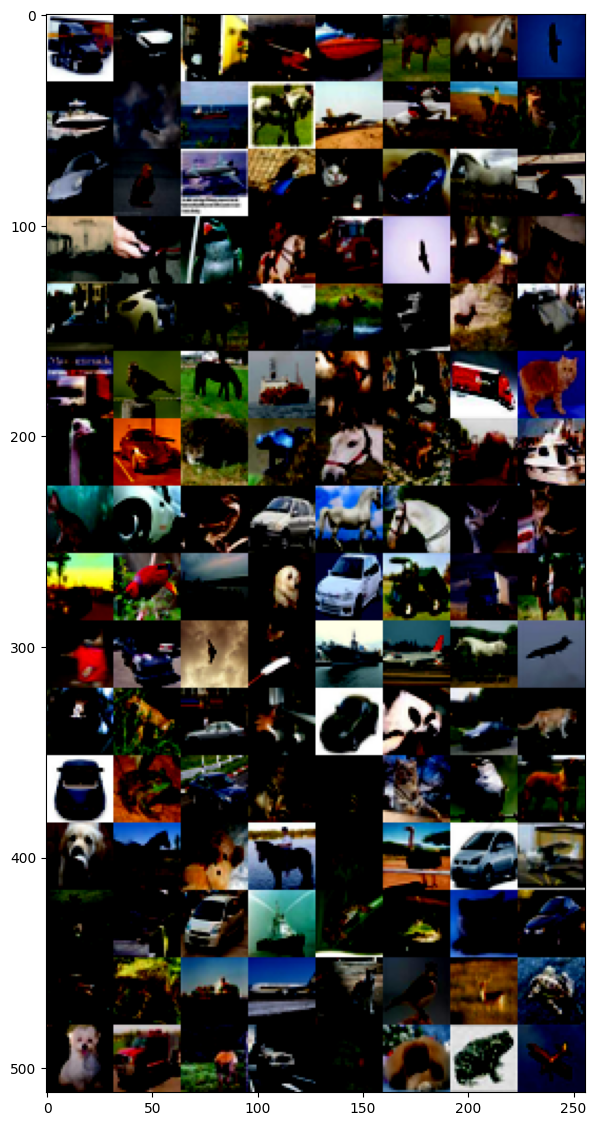

In [ ]:
img = utils.make_grid(images, padding=0)
npimg = img.numpy()

plt.figure(figsize=(20, 14))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
pred = model(images.to(DEVICE))
y_pred = pred.max(1, keepdim=True)[1].view(-1)

In [ ]:
y_pred, labels

(tensor([9, 1, 9, 0, 9, 7, 7, 2, 8, 0, 8, 7, 0, 7, 7, 2, 1, 2, 0, 2, 3, 1, 7, 3,
         8, 5, 2, 7, 9, 2, 2, 7, 1, 1, 4, 9, 4, 9, 4, 5, 9, 2, 7, 8, 5, 5, 9, 3,
         2, 1, 3, 2, 7, 5, 9, 8, 3, 1, 2, 1, 7, 7, 2, 3, 9, 2, 8, 5, 1, 9, 9, 7,
         5, 1, 0, 3, 8, 0, 7, 0, 2, 6, 1, 3, 1, 3, 1, 3, 1, 6, 1, 3, 6, 3, 2, 5,
         5, 7, 5, 7, 4, 2, 1, 0, 4, 2, 1, 8, 6, 6, 3, 1, 1, 6, 8, 0, 7, 2, 4, 6,
         5, 9, 4, 1, 4, 5, 6, 0], device='cuda:0'),
 tensor([9, 1, 9, 0, 8, 7, 7, 2, 8, 0, 8, 7, 0, 7, 7, 2, 1, 2, 0, 2, 3, 1, 7, 3,
         8, 5, 2, 7, 9, 2, 2, 7, 1, 1, 4, 9, 4, 9, 4, 1, 9, 2, 7, 8, 3, 5, 9, 3,
         2, 1, 3, 6, 7, 5, 9, 8, 3, 1, 2, 1, 7, 7, 2, 3, 9, 2, 8, 5, 1, 9, 9, 7,
         5, 1, 0, 3, 8, 0, 7, 0, 2, 6, 1, 3, 1, 3, 1, 3, 1, 6, 1, 3, 6, 3, 2, 5,
         5, 7, 5, 7, 4, 2, 1, 0, 4, 2, 1, 8, 6, 6, 3, 1, 1, 6, 8, 0, 3, 2, 4, 6,
         5, 9, 4, 1, 4, 5, 6, 0]))

In [ ]:
pred = model(images.to(DEVICE))
y_pred = pred.max(1, keepdim=True)[1].view(-1)

In [ ]:
y_pred, labels

(tensor([9, 1, 9, 0, 9, 7, 7, 2, 8, 0, 8, 7, 0, 7, 7, 2, 1, 2, 0, 2, 3, 1, 7, 3,
         8, 5, 2, 7, 9, 2, 2, 7, 1, 1, 4, 9, 4, 9, 4, 5, 9, 2, 7, 8, 5, 5, 9, 3,
         2, 1, 3, 2, 7, 5, 9, 8, 3, 1, 2, 1, 7, 7, 2, 3, 9, 2, 8, 5, 1, 9, 9, 7,
         5, 1, 0, 3, 8, 0, 7, 0, 2, 6, 1, 3, 1, 3, 1, 3, 1, 6, 1, 3, 6, 3, 2, 5,
         5, 7, 5, 7, 4, 2, 1, 0, 4, 2, 1, 8, 6, 6, 3, 1, 1, 6, 8, 0, 7, 2, 4, 6,
         5, 9, 4, 1, 4, 5, 6, 0], device='cuda:0'),
 tensor([9, 1, 9, 0, 8, 7, 7, 2, 8, 0, 8, 7, 0, 7, 7, 2, 1, 2, 0, 2, 3, 1, 7, 3,
         8, 5, 2, 7, 9, 2, 2, 7, 1, 1, 4, 9, 4, 9, 4, 1, 9, 2, 7, 8, 3, 5, 9, 3,
         2, 1, 3, 6, 7, 5, 9, 8, 3, 1, 2, 1, 7, 7, 2, 3, 9, 2, 8, 5, 1, 9, 9, 7,
         5, 1, 0, 3, 8, 0, 7, 0, 2, 6, 1, 3, 1, 3, 1, 3, 1, 6, 1, 3, 6, 3, 2, 5,
         5, 7, 5, 7, 4, 2, 1, 0, 4, 2, 1, 8, 6, 6, 3, 1, 1, 6, 8, 0, 3, 2, 4, 6,
         5, 9, 4, 1, 4, 5, 6, 0]))

In [ ]:
y_pred_ = y_pred.cpu().numpy()
labels_ = labels.numpy()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred_, labels_)

0.9609375